In [1]:
%%time
import pandas as pd
import numpy as np
import statistics
import os
import random
import MeCab 
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option("display.precision", 8)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
#     tf.random.set_seed(seed)
    


# seed
seed = 817
seed_everything(seed)

# load train test
train = pd.read_csv('../../data/input/probspace/train_data.csv')
train['y_bin'] = pd.cut(train['y'], [0, 10, 100,1000,10000,100000,1000000,10000000000], labels=[1,2,3,4,5,6,7])
train['y_bin'] = train['y_bin'].astype(int)
test = pd.read_csv('../../data/input/probspace/test_data.csv')
df = pd.concat([train,test],axis=0).reset_index(drop=True)
print ('train',train.shape)
print ('test',test.shape)
df['comments_ratings'] = df['comments_disabled'].astype(str)+df['ratings_disabled'].astype(str)
    
for c in ['channelId','channelTitle','collection_date','description','tags','comments_disabled','ratings_disabled','comments_ratings']:
    lbl = LabelEncoder()
    df[c+'_encoder'] = lbl.fit_transform(df[c].astype(str))
    
df['length_title'] = [len(d) for d in df['title']]
    
# use predicted dislikes,likes,comment_out
dislikes_pred = pd.read_csv('../../data/input/probspace/dislikes_pred_0623.csv')
likes_pred = pd.read_csv('../../data/input/probspace/likes_pred_0623.csv')
comments_pred = pd.read_csv('../../data/input/probspace/comment_count_pred_0623.csv')
df = df.merge(dislikes_pred,on=['video_id'],how='left')
df = df.merge(likes_pred,on=['video_id'],how='left')
df = df.merge(comments_pred,on=['video_id'],how='left')
df['diff_dislikes'] = df['dislikes'] - df['dislikes_pred']
df['diff_likes'] = df['likes'] - df['likes_pred']
df['diff_comments'] = df['comment_count'] - df['comment_count_pred']
df['original_dislikes'] = df['dislikes']
df['original_likes'] = df['likes']
df['original_comment_count'] = df['comment_count']
# disableされている値を予測した値に入れ替える。
df.loc[df['ratings_disabled']==True,'dislikes'] = df.loc[df['ratings_disabled']==True,'dislikes_pred']
df.loc[df['ratings_disabled']==True,'likes'] = df.loc[df['ratings_disabled']==True,'likes_pred']
df.loc[df['comments_disabled']==True,'comment_count'] = df.loc[df['comments_disabled']==True,'comment_count_pred']

# timestamp transformation
df["c_date"] = "20" + df["collection_date"]
df["c_date"] = pd.to_datetime(df["c_date"], utc=True, format="%Y.%d.%m")
df["c_year"] = df["c_date"].dt.year
df["c_month"] = df["c_date"].dt.month
df["c_day"] = df["c_date"].dt.day
df["c_dayofweek"] = df["c_date"].dt.dayofweek

df["publishedAt"] = pd.to_datetime(df["publishedAt"],utc=True, format="%Y-%m-%d")
df["past"] = (df["publishedAt"].dt.floor("D").max() - df["publishedAt"].dt.floor("D")).dt.days
df["year"] = df["publishedAt"].dt.year
df["month"] = df["publishedAt"].dt.month
df["weekofyear"] = df["publishedAt"].dt.weekofyear
df["day"] = df["publishedAt"].dt.day
df["dayofweek"] = df["publishedAt"].dt.dayofweek
df["hour"] = df["publishedAt"].dt.hour
df["minute"] = df["publishedAt"].dt.minute    

# 公開されてからの収集するまで日数
df['seconds_from_publish'] = (df['c_date'] - df['publishedAt']).dt.seconds
df['days_from_publish'] = (df['c_date'] - df['publishedAt']).dt.days
df['months_from_publish'] = (df['c_date'] - df['publishedAt']).dt.days // 30
df['years_from_publish'] = (df['c_date'] - df['publishedAt']).dt.days // 365

# YouTubeが解説されてから公開までの日数 
df['days_from_publish_start'] = (df['publishedAt'] - df['publishedAt'].min()).dt.days
df['month_from_publish_start'] = (df['publishedAt'] - df['publishedAt'].min()).dt.days // 30
df['year_from_publish_start'] = (df['publishedAt'] - df['publishedAt'].min()).dt.days // 365

# データ収取を始めてからの日数
df['days_from_cdate_start'] = (df['c_date'] - df['c_date'].min()).dt.days

# youtubeができてからの1日あたりのlike数、dislike数、コメント数
df['like_per_published_day'] = (df['likes'] / df['days_from_publish_start']).replace([np.inf, -np.inf], 0)
df['dislike_per_published_day'] = (df['dislikes'] / df['days_from_publish_start']).replace([np.inf, -np.inf], 0)
df['comment_count_per_published_day'] = (df['comment_count'] / df['days_from_publish_start']).replace([np.inf, -np.inf], 0)

# youtubeができてからの1ヶ月あたりのlike数、dislike数、コメント数
df['like_per_published_month'] = (df['likes'] / df['month_from_publish_start']).replace([np.inf, -np.inf], 0)
df['dislike_per_published_month'] = (df['dislikes'] / df['month_from_publish_start']).replace([np.inf, -np.inf], 0)
df['comment_count_per_published_month'] = (df['comment_count'] / df['month_from_publish_start']).replace([np.inf, -np.inf], 0)

# youtubeができてからの1年あたりのlike数、dislike数、コメント数
df['like_per_published_year'] = (df['likes'] / df['year_from_publish_start']).replace([np.inf, -np.inf], 0)
df['dislike_per_published_year'] = (df['dislikes'] / df['year_from_publish_start']).replace([np.inf, -np.inf], 0)
df['comment_count_per_published_year'] = (df['comment_count'] / df['year_from_publish_start']).replace([np.inf, -np.inf], 0)

# interaction 
df['comments_disabled'] = df['comments_disabled'].map(lambda x:1 if x==True else 0)
df['ratings_disabled'] = df['ratings_disabled'].map(lambda x:1 if x==True else 0)

df['likes_comments'] = df['likes'] * df['comments_disabled']
df['dislikes_comments'] = df['dislikes'] * df['comments_disabled']
df['comment_count_ratings'] = df['comment_count'] * df['ratings_disabled']

df['comments_ratings_disabled'] = df['comments_disabled'] + df['ratings_disabled']
df['diff_likes_dislikes'] = df['likes'] - df['dislikes'] 
df['ratio_likes_dislikes'] = df['likes'] / (df['dislikes'] + 1)
df['ratio_likes_comment_count'] = df['likes'] / (df['comment_count'] + 1)
df['ratio_dislikes_comment_count'] = df['dislikes'] / (df['comment_count'] + 1)

# 1日あたりのlike数、dislike数、コメント数
df['likes_by_day'] = df['likes'] / df['days_from_publish']
df['dislikes_by_day'] = df['dislikes'] / df['days_from_publish']
df['comments_by_day'] = df['comment_count'] / df['days_from_publish']

# 1ヶ月あたりのlike数、dislike数、コメント数
df['likes_by_month'] = df['likes'] / df['months_from_publish']
df['dislikes_by_month'] = df['dislikes'] / df['months_from_publish']
df['comments_by_month'] = df['comment_count'] / df['months_from_publish']

# 1年あたりのlike数、dislike数、コメント数
df['likes_by_year'] = df['likes'] / df['years_from_publish']
df['dislikes_by_year'] = df['dislikes'] / df['years_from_publish']
df['comments_by_year'] = df['comment_count'] / df['years_from_publish']

# 標準得点
df['likes_std_score'] = (df['likes'] - df['likes'].mean()) / statistics.stdev(list(df['likes']))
df['dislikes_std_score'] = (df['dislikes'] - df['dislikes'].mean()) / statistics.stdev(list(df['dislikes']))
df['commentss_std_score'] = (df['comment_count'] - df['comment_count'].mean()) / statistics.stdev(list(df['comment_count']))

print ('df',df.shape)
display(df.head())
display(df.columns.values)

train (19720, 18)
test (29582, 16)
df (49302, 87)


,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y,y_bin,comments_ratings,channelId_encoder,channelTitle_encoder,collection_date_encoder,description_encoder,tags_encoder,comments_disabled_encoder,ratings_disabled_encoder,comments_ratings_encoder,length_title,dislikes_pred,likes_pred,comment_count_pred,diff_dislikes,diff_likes,diff_comments,original_dislikes,original_likes,original_comment_count,c_date,c_year,c_month,c_day,c_dayofweek,past,year,month,weekofyear,day,dayofweek,hour,minute,seconds_from_publish,days_from_publish,months_from_publish,years_from_publish,days_from_publish_start,month_from_publish_start,year_from_publish_start,days_from_cdate_start,like_per_published_day,dislike_per_published_day,comment_count_per_published_day,like_per_published_month,dislike_per_published_month,comment_count_per_published_month,like_per_published_year,dislike_per_published_year,comment_count_per_published_year,likes_comments,dislikes_comments,comment_count_ratings,comments_ratings_disabled,diff_likes_dislikes,ratio_likes_dislikes,ratio_likes_comment_count,ratio_dislikes_comment_count,likes_by_day,dislikes_by_day,comments_by_day,likes_by_month,dislikes_by_month,comments_by_month,likes_by_year,dislikes_by_year,comments_by_year,likes_std_score,dislikes_std_score,commentss_std_score
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09 05:50:33+00:00,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyoui|no|Shinryakusha|sekai|he|chosen|challenge|to|the|world|anime|game|ds|music|soundtrack|background|t-pistonz+kmc|berryz|fire|blizzard|spark|bomber|ogre|rip|endou|endo|mark|goenji|kidou|fubuki|aki|kazemaru|someoka|kabeyama|alien|hiroto|midorikawa|song|themes|battle|ffi,114.0,0.0,7.0,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,0,0,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (Ripped by Tommy),29229.0,5.0,FalseFalse,7498,2223,5,28187,7094,0,0,0,42,4.37847386,69.14827722,10.95780610,-4.37847386,44.85172278,-3.95780610,0,114,7,2020-02-01 00:00:00+00:00,2020,2,1,5,3268,2011,1,1,9,6,5,50,65367,3309,110,9,2086,69,5,41,0.05465005,0.00000000,0.00335570,1.65217391,0.00000000,0.10144928,22.80000000,0.00000000,1.40000000,0.0,0.0,0.0,0,114.0,114.00000000,14.25000000,0.00000000,0.03445150,0.00000000,0.00211544,1.03636364,0.00000000,0.06363636,12.66666667,0.00000000,0.77777778,-0.12927468,-0.08150842,-0.05837709
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23 03:00:09+00:00,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデンティティ|放課後ミッドナイターズ|ナースフル|竹清仁|ループ|シャープ|shrap ♯|蒼山幸子|澤村小夜子|藤咲佑|沙田瑞紀|Hello! Z|ex Negoto,2885.0,50.0,111.0,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,0,0,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞紀（G)、藤咲佑（Ba）、澤村小夜子（Dr）からなるオルタナティブでファンタジックなロックを鳴らすガールズ4ピースバンド＜ねごと＞。2011年7月13日リリースの1st Full Album「ex Negoto」より「メルシールー」。孤独になってしまったとき、胸の奥にしまっていた大切なことを思い出せたら、すべてがまぶしく見える、そんな瞬間を描いた歌詞と相成る楽曲はシンセ音がエッセンスとなったライブでも盛り上がり必至のナンバー。,730280.0,6.0,FalseFalse,12289,15874,12,26010,29252,0,0,0,35,64.04819316,3159.78843121,102.95138114,-14.04819316,-274.78843121,8.04861886,50,2885,111,2020-02-08 00:00:00+00:00,2020,2,8,5,2707,2012,7,30,23,0,3,0,75591,2755,91,7,2646,88,7,48,1.09032502,0.01889645,0.04195011,32.78409091,0.56818182,1.26136364,412.14285714,7.14285714,15.85714286,0.0,0.0,0.0,0,2835.0,56.56862745,25.75892857,0.44642857,1.04718693,0.01814882,0.04029038,31.70329670,0.54945055,1.21978022,412.14285714,7.14285714,15.85714286,-0.10644434,-0.07668421,-0.05324998
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26 13:54:09+00:00,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|sega|バーチャ,133.0,17.0,14.0,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,0,0,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667.0,5.0,FalseFalse,3392,14185,16,5711,16068,0,0,0,22,6.45271986,85.109761

array(['id', 'video_id', 'title', 'publishedAt', 'channelId',
       'channelTitle', 'categoryId', 'collection_date', 'tags', 'likes',
       'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled',
       'ratings_disabled', 'description', 'y', 'y_bin',
       'comments_ratings', 'channelId_encoder', 'channelTitle_encoder',
       'collection_date_encoder', 'description_encoder', 'tags_encoder',
       'comments_disabled_encoder', 'ratings_disabled_encoder',
       'comments_ratings_encoder', 'length_title', 'dislikes_pred',
       'likes_pred', 'comment_count_pred', 'diff_dislikes', 'diff_likes',
       'diff_comments', 'original_dislikes', 'original_likes',
       'original_comment_count', 'c_date', 'c_year', 'c_month', 'c_day',
       'c_dayofweek', 'past', 'year', 'month', 'weekofyear', 'day',
       'dayofweek', 'hour', 'minute', 'seconds_from_publish',
       'days_from_publish', 'months_from_publish', 'years_from_publish',
       'days_from_publish_start', 'month_fro

CPU times: user 3.48 s, sys: 810 ms, total: 4.29 s
Wall time: 5.99 s


In [2]:
%%time
import MeCab

# 分かち書きオブジェクト
tagger = MeCab.Tagger('')

# 安定するらしい
tagger.parse('')

def text_split_to_word(text):
    node = tagger.parseToNode(text)
    terms = []
    select_conditions = ['動詞', '形容詞', '名詞', '形容動詞']

    while node:
        # 単語
        term = node.surface
        # 品詞
        pos = node.feature.split(',')[0]
        # もし品詞が条件と一致してたら
        if pos in select_conditions:
            terms.append(term)

        node = node.next

    # 連結おじさん
    text_result = ' '.join(terms)
    return text_result
    
for i in ["channelTitle", "title"]:
    split_words = []
    for text in list(df[i]):
        split_words.append(text_split_to_word(text))
    df[i] = split_words
    
df['new_tags'] = df['tags'].astype(str).apply(lambda x: x.replace('|',' '))
df["description"] = df["description"].astype(str)   

CPU times: user 2.18 s, sys: 191 ms, total: 2.37 s
Wall time: 3.42 s


In [3]:

%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
n_comp = 100

for i in ['channelTitle','title']:#,'new_title','new_description',
    print (i)
    tfidf_vec = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
    text_tfidf = tfidf_vec.fit_transform(df[i].values.tolist() )
    text_svd = TruncatedSVD(n_components=n_comp, algorithm='arpack',random_state=9999)
    df_svd = pd.DataFrame(text_svd.fit_transform(text_tfidf))
    df_svd.columns = ['svd_'+str(i)+str(j+1) for j in range(n_comp)]
    df = pd.concat([df,df_svd],axis=1)
    
for i in ['new_tags',]:
    print (i)
    tfidf_vec = TfidfVectorizer(analyzer='word',ngram_range=(1,1))
    text_tfidf = tfidf_vec.fit_transform(df[i].values.tolist() )
    text_svd = TruncatedSVD(n_components=n_comp, algorithm='arpack',random_state=9999)
    df_svd = pd.DataFrame(text_svd.fit_transform(text_tfidf))
    df_svd.columns = ['svd_char_'+str(i)+str(j+1) for j in range(n_comp)]
    df = pd.concat([df,df_svd],axis=1)


channelTitle
title
new_tags
CPU times: user 1min 5s, sys: 3.27 s, total: 1min 8s
Wall time: 43.7 s


In [4]:
%%time
from tqdm import tqdm
from scipy import stats
def agg(df,agg_cols):
    for c in tqdm(agg_cols):
        new_feature = '{}_{}_{}'.format('_'.join(c['groupby']), c['agg'], c['target'])

        if c['agg'] == 'mean_diff':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('mean') - df[c['target']]
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'mean_ratio':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('mean') / (1+df[c['target']])
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'trim_mean':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform(lambda x: stats.trim_mean(x, 0.1))
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'trim_mean_diff':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform(lambda x: stats.trim_mean(x, 0.1)) - df[c['target']]
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'max_diff':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('max') - df[c['target']]
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'max_ratio':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('max') / (1+df[c['target']])
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'min_diff':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('min')- df[c['target']]
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'min_ratio':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('min')/ (1+df[c['target']])
            df[new_feature+'_rank'] = df.groupby(c['groupby'])[c['target']].rank()
        elif c['agg'] == 'max_min_diff':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('max') - df.groupby(c['groupby'])[c['target']].transform('min')
        elif c['agg'] == 'max_min_ratio':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('max') / (1+df.groupby(c['groupby'])[c['target']].transform('min'))             
        elif c['agg'] == 'median_diff':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('median') - df[c['target']]
        elif c['agg'] == 'median_ratio':
            df[new_feature] = df.groupby(c['groupby'])[c['target']].transform('median') / (1+df[c['target']])     
    return df

agg_cols = [


    
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'trim_mean'}, 
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'trim_mean_diff'},
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'max_diff'},
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'max_ratio'},
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'mean_ratio'},
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'mean_diff'}, 
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'min_diff'},     
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'min_ratio'},   
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'max_min_diff'},
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'max_min_ratio'},     
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'median_diff'},    
    {'groupby': ['categoryId'], 'target':'likes', 'agg':'median_ratio'},
    
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'trim_mean'}, 
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'trim_mean_diff'},
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'max_diff'},
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'max_ratio'},
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'mean_ratio'},
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'min_diff'},     
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'min_ratio'},   
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'max_min_diff'},
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'max_min_ratio'},     
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'median_diff'},    
    {'groupby': ['categoryId'], 'target':'dislikes', 'agg':'median_ratio'},
    

    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'trim_mean'}, 
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'trim_mean_diff'},
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'max_diff'},
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'max_ratio'},
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'mean_ratio'},
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'mean_diff'}, 
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'min_diff'},     
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'min_ratio'},   
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'max_min_diff'},
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'max_min_ratio'},     
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'median_diff'},    
    {'groupby': ['categoryId'], 'target':'comment_count', 'agg':'median_ratio'},



    {'groupby': ['year'], 'target':'likes', 'agg':'trim_mean'}, 
    {'groupby': ['year'], 'target':'likes', 'agg':'trim_mean_diff'},
    {'groupby': ['year'], 'target':'likes', 'agg':'max_diff'},
    {'groupby': ['year'], 'target':'likes', 'agg':'max_ratio'},
    {'groupby': ['year'], 'target':'likes', 'agg':'mean_ratio'},
    {'groupby': ['year'], 'target':'likes', 'agg':'mean_diff'}, 
    {'groupby': ['year'], 'target':'likes', 'agg':'min_diff'},     
    {'groupby': ['year'], 'target':'likes', 'agg':'min_ratio'},   
    {'groupby': ['year'], 'target':'likes', 'agg':'max_min_diff'},
    {'groupby': ['year'], 'target':'likes', 'agg':'max_min_ratio'},     
    {'groupby': ['year'], 'target':'likes', 'agg':'median_diff'},    
    {'groupby': ['year'], 'target':'likes', 'agg':'median_ratio'},

    

    {'groupby': ['year'], 'target':'dislikes', 'agg':'trim_mean'}, 
    {'groupby': ['year'], 'target':'dislikes', 'agg':'trim_mean_diff'},
    {'groupby': ['year'], 'target':'dislikes', 'agg':'max_diff'},
    {'groupby': ['year'], 'target':'dislikes', 'agg':'max_ratio'},
    {'groupby': ['year'], 'target':'dislikes', 'agg':'mean_ratio'},
    {'groupby': ['year'], 'target':'dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['year'], 'target':'dislikes', 'agg':'min_diff'},     
    {'groupby': ['year'], 'target':'dislikes', 'agg':'min_ratio'},   
    {'groupby': ['year'], 'target':'dislikes', 'agg':'max_min_diff'},
    {'groupby': ['year'], 'target':'dislikes', 'agg':'max_min_ratio'},     
    {'groupby': ['year'], 'target':'dislikes', 'agg':'median_diff'},    
    {'groupby': ['year'], 'target':'dislikes', 'agg':'median_ratio'},
    

    {'groupby': ['year'], 'target':'comment_count', 'agg':'trim_mean'}, 
    {'groupby': ['year'], 'target':'comment_count', 'agg':'trim_mean_diff'},
    {'groupby': ['year'], 'target':'comment_count', 'agg':'max_diff'},
    {'groupby': ['year'], 'target':'comment_count', 'agg':'max_ratio'},
    {'groupby': ['year'], 'target':'comment_count', 'agg':'mean_ratio'},
    {'groupby': ['year'], 'target':'comment_count', 'agg':'mean_diff'}, 
    {'groupby': ['year'], 'target':'comment_count', 'agg':'min_diff'},     
    {'groupby': ['year'], 'target':'comment_count', 'agg':'min_ratio'},   
    {'groupby': ['year'], 'target':'comment_count', 'agg':'max_min_diff'},
    {'groupby': ['year'], 'target':'comment_count', 'agg':'max_min_ratio'},     
    {'groupby': ['year'], 'target':'comment_count', 'agg':'median_diff'},    
    {'groupby': ['year'], 'target':'comment_count', 'agg':'median_ratio'},
    

    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'trim_mean'}, 
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'trim_mean_diff'},
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'max_diff'},
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'max_ratio'},
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'mean_ratio'},
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'min_diff'},     
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'min_ratio'},   
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'max_min_diff'},
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'max_min_ratio'},     
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'median_diff'},    
    {'groupby': ['channelTitle_encoder'], 'target':'diff_likes_dislikes', 'agg':'median_ratio'},


    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'trim_mean'}, 
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'trim_mean_diff'},
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'max_diff'},
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'max_ratio'},
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'mean_ratio'},
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'min_diff'},     
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'min_ratio'},   
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'max_min_diff'},
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'max_min_ratio'},     
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'median_diff'},    
    {'groupby': ['categoryId'], 'target':'diff_likes_dislikes', 'agg':'median_ratio'},

    

    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'trim_mean'}, 
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'trim_mean_diff'},
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'max_diff'},
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'max_ratio'},
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'mean_ratio'},
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'min_diff'},     
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'min_ratio'},   
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'max_min_diff'},
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'max_min_ratio'},     
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'median_diff'},    
    {'groupby': ['year'], 'target':'diff_likes_dislikes', 'agg':'median_ratio'},
     

 
    {'groupby': ['ratings_disabled'], 'target':'likes', 'agg':'mean_diff'}, 
    {'groupby': ['ratings_disabled'], 'target':'likes', 'agg':'mean_ratio'}, 
    
    {'groupby': ['ratings_disabled'], 'target':'dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['ratings_disabled'], 'target':'dislikes', 'agg':'mean_ratio'},    
    
  
    {'groupby': ['ratings_disabled'], 'target':'comment_count', 'agg':'mean_diff'}, 
    {'groupby': ['ratings_disabled'], 'target':'comment_count', 'agg':'mean_ratio'}, 
       
    {'groupby': ['comments_disabled'], 'target':'likes', 'agg':'mean_diff'}, 
    {'groupby': ['comments_disabled'], 'target':'likes', 'agg':'mean_ratio'}, 

    {'groupby': ['comments_disabled'], 'target':'dislikes', 'agg':'mean_diff'}, 
    {'groupby': ['comments_disabled'], 'target':'dislikes', 'agg':'mean_ratio'},    
       
    {'groupby': ['comments_disabled'], 'target':'comment_count', 'agg':'mean_diff'}, 
    {'groupby': ['comments_disabled'], 'target':'comment_count', 'agg':'mean_ratio'},     
    
   ]

df = agg(df,agg_cols)

100%|██████████| 120/120 [00:14<00:00,  8.53it/s]

CPU times: user 12.1 s, sys: 630 ms, total: 12.7 s
Wall time: 14.1 s


In [5]:
%%time
text_cols = ['channelTitle','description','title','new_tags']
for cols in text_cols:   
    df[cols] = df[cols].astype(str) 
 
    df[cols +'_music'] = df[cols].apply(lambda x: 1 if 'music' in x.lower() else 0)
    df[cols +'_official'] = df[cols].apply(lambda x: 1 if 'official' in x.lower() else 0)
    df[cols +'_ja_official'] = df[cols].apply(lambda x: 1 if '公式' in x else 0) 
    df[cols +'_cm'] = df[cols].apply(lambda x: 1 if 'cm' in x.lower() else 0)     
    df[cols +'_http'] = df[cols].apply(lambda x: 1 if 'http' in x.lower() else 0)    
    df[cols +'_movie'] = df[cols].apply(lambda x: 1 if 'movie' in x.lower() else 0)    
    df[cols +'_jp'] = df[cols].apply(lambda x: 1 if 'jp' in x.lower() else 0)     
    df[cols +'_youtube'] = df[cols].apply(lambda x: 1 if 'youtube' in x.lower() else 0)         
    df[cols +'_jp_movie'] = df[cols].apply(lambda x: 1 if '映画' in x else 0)      
    df[cols +'_jp_director'] = df[cols].apply(lambda x: 1 if '監督' in x else 0)       
    df[cols +'_jp_tohaku'] = df[cols].apply(lambda x: 1 if '東宝' in x else 0)

CPU times: user 3.08 s, sys: 63 ms, total: 3.14 s
Wall time: 3.68 s


In [6]:
from sklearn.model_selection import StratifiedKFold

df2 = df.copy()
train_df = df2[df2['y'].notnull()]
train_df['y'] = np.log1p(train_df['y'])
test_df = df2[df2['y'].isnull()] 

drop_features=[ 'channelId', 'channelTitle', 'c_date','collection_date','image','comments_ratings_disabled',
        'description', 'ratio_title_des','comments_disabled','ratings_disabled',
       'id',  'publishedAt',  'tags','new_tags','all_text','new_title', 'new_description',
       'thumbnail_link', 'title', 'video_id', 'y','y_bin','lgb_y','comments_ratings',
 
 'month_sum_likes', 'month_mean_likes', 'month_max_likes', 'month_min_likes', 'month_std_likes', 'month_mean_diff_likes', 'month_mean_ratio_likes', 
               'month_sum_dislikes', 'month_mean_dislikes', 'month_max_dislikes', 'month_min_dislikes', 'month_std_dislikes', 'month_mean_diff_dislikes',
               'month_mean_ratio_dislikes', 'month_sum_comment_count', 'month_mean_comment_count', 'month_max_comment_count', 'month_min_comment_count', 
               'month_std_comment_count', 'month_mean_diff_comment_count', 'month_mean_ratio_comment_count',
               'dayofweek_sum_likes', 'dayofweek_mean_likes', 'dayofweek_max_likes', 'dayofweek_min_likes', 'dayofweek_std_likes', 'dayofweek_mean_diff_likes', 
               'dayofweek_mean_ratio_likes', 'dayofweek_sum_dislikes', 'dayofweek_mean_dislikes', 'dayofweek_max_dislikes', 'dayofweek_min_dislikes', 'dayofweek_std_dislikes',
               'dayofweek_mean_diff_dislikes', 'dayofweek_mean_ratio_dislikes', 'dayofweek_sum_comment_count', 'dayofweek_mean_comment_count', 'dayofweek_max_comment_count', 'dayofweek_min_comment_count', 
               'dayofweek_std_comment_count', 'dayofweek_mean_diff_comment_count', 'dayofweek_mean_ratio_comment_count', 
               'hour_sum_likes', 'hour_mean_likes', 'hour_max_likes', 'hour_min_likes', 'hour_std_likes', 'hour_mean_diff_likes', 'hour_mean_ratio_likes',
               'hour_sum_dislikes', 'hour_mean_dislikes', 'hour_max_dislikes', 'hour_min_dislikes', 'hour_std_dislikes', 'hour_mean_diff_dislikes',
               'hour_mean_ratio_dislikes', 'hour_sum_comment_count', 'hour_mean_comment_count', 'hour_max_comment_count', 'hour_min_comment_count',
               'hour_std_comment_count', 'hour_mean_diff_comment_count', 'hour_mean_ratio_comment_count',   
'seconds_from_publish',  
'c_year',
'categoryId_min_likes', 
'categoryId_min_dislikes', 
'categoryId_min_comment_count', 
'year_min_likes', 
'year_min_dislikes', 
'year_min_comment_count',            
'residual',
               'svd_description1', 'svd_description2', 'svd_description3', 'svd_description4', 'svd_description5', 
               'svd_description6', 'svd_description7', 'svd_description8', 'svd_description9', 'svd_description10',
               'svd_description11', 'svd_description12', 'svd_description13', 'svd_description14', 'svd_description15',
               'svd_description16', 'svd_description17', 'svd_description18', 'svd_description19', 'svd_description20',      
                               
              ]

seed = 817
folds = StratifiedKFold(n_splits=8, shuffle=True, random_state=seed)
target = 'y'

 
features = [f for f in train_df.columns if f not in drop_features]

cat_features = [
    'categoryId',
    'channelTitle_encoder', 
    'comments_ratings_encoder',
    'c_month', 
    'year', 
]

print ('numerical features:', len(features),features)# 

numerical features: 616 ['categoryId', 'likes', 'dislikes', 'comment_count', 'channelId_encoder', 'channelTitle_encoder', 'collection_date_encoder', 'description_encoder', 'tags_encoder', 'comments_disabled_encoder', 'ratings_disabled_encoder', 'comments_ratings_encoder', 'length_title', 'dislikes_pred', 'likes_pred', 'comment_count_pred', 'diff_dislikes', 'diff_likes', 'diff_comments', 'original_dislikes', 'original_likes', 'original_comment_count', 'c_month', 'c_day', 'c_dayofweek', 'past', 'year', 'month', 'weekofyear', 'day', 'dayofweek', 'hour', 'minute', 'days_from_publish', 'months_from_publish', 'years_from_publish', 'days_from_publish_start', 'month_from_publish_start', 'year_from_publish_start', 'days_from_cdate_start', 'like_per_published_day', 'dislike_per_published_day', 'comment_count_per_published_day', 'like_per_published_month', 'dislike_per_published_month', 'comment_count_per_published_month', 'like_per_published_year', 'dislike_per_published_year', 'comment_count_pe

In [9]:
###### %%time
import lightgbm as lgb
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))** .5

def target_encoder_kfold(train_df,test_df,col,target,folds,method):
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_df['y_bin'])):
        print ('FOLD:' + str(n_fold))
        train_x = train_df.iloc[train_idx]
        valid_x = train_df.iloc[valid_idx] 
        if method == 'mean':
            oof_preds[valid_idx] = valid_x[col].map(train_x.groupby(col)[target].apply(lambda x: stats.trim_mean(x, 0.01)))
        if method == 'median':
            oof_preds[valid_idx] = valid_x[col].map(train_x.groupby(col)[target].median())   
        if method == 'max':
            oof_preds[valid_idx] = valid_x[col].map(train_x.groupby(col)[target].max())  
        if method == 'min':
            oof_preds[valid_idx] = valid_x[col].map(train_x.groupby(col)[target].min())              
    if method == 'mean':    
        sub_preds = test_df[col].map(train_df.groupby(col)[target].apply(lambda x: stats.trim_mean(x, 0.01)))
    if method == 'median':    
        sub_preds = test_df[col].map(train_df.groupby(col)[target].median())
    if method == 'max':    
        sub_preds = test_df[col].map(train_df.groupby(col)[target].max())
    if method == 'min':    
        sub_preds = test_df[col].map(train_df.groupby(col)[target].min())        
    return oof_preds,sub_preds


def lgb_k_fold(train_df, test_df, features, target, cat_features, folds, params, use_pseudo=False, sampling=False):
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])

    cv_list = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[features], train_df['y_bin'])):
        print ('FOLD:' + str(n_fold))
        print("train idx is {} and valid idx is {}".format(train_idx, valid_idx))
        print("train idx length is {} and valid idx length is {}".format(len(train_idx), len(valid_idx)))
        
        train_x, train_y = train_df[features].iloc[train_idx], train_df[target].iloc[train_idx]
        valid_x, valid_y = train_df[features].iloc[valid_idx], train_df[target].iloc[valid_idx]
        
        # remove outliers
        if sampling is True:
            valid_x, valid_y = train_df[features].iloc[valid_idx], train_df[target].iloc[valid_idx] 
            train_df_new = train_df.iloc[train_idx]
            train_df_new = train_df_new[train_df_new['y_residual']<3.2]#3
            train_x, train_y = train_df_new[features], train_df_new[target]
            
       # pseudo 
        if use_pseudo is True:
            train_x = pd.concat([train_x, pseudo[features]], axis=0)
            train_y = train_y.append(pseudo[target])  
            for n, (pseudo_train_idx, pseudo_valid_idx) in enumerate(folds.split(pseudo[features], pseudo['y_bin'])):
                print ('PSEUDO FOLD:' + str(n))
                if n_fold == n:
                    train_x = pd.concat([train_x, pseudo[features].iloc[pseudo_valid_idx]],axis=0)
                    train_y = train_y.append(pseudo[target].iloc[pseudo_valid_idx] )
                    break
                    
        print ('train_x shape:',train_x.shape,train_y.mean())
        print ('valid_x shape:',valid_x.shape,valid_y.mean())
        
        dtrain = lgb.Dataset(train_x, label=train_y,categorical_feature=cat_features)
        dval = lgb.Dataset(valid_x, label=valid_y, reference=dtrain,categorical_feature=cat_features)

        bst = lgb.train(params, dtrain, num_boost_round=50000,
            valid_sets=[dval,dtrain], verbose_eval=500,early_stopping_rounds=500, )

        # output feature importance
        feature_importances = sorted(zip(features, bst.feature_importance('gain')),key=lambda x: x[1], reverse=True)
        sum_fi = []
        for fi in feature_importances:
            sum_fi.append(fi[1])
        
        sum_fi = sum(sum_fi)
        
        for fi in feature_importances[:30]:
            print("効果的な特徴量", fi)
            print(fi[1]/sum_fi)
        
        # 訓練データを利用
        # 交差検証で得られたvalidのインデックスの場所に予測値をいれる
        oof_preds[valid_idx] = bst.predict(valid_x, num_iteration=bst.best_iteration)
        # RMSE
        oof_cv = rmse(valid_y,  oof_preds[valid_idx])
        cv_list.append(oof_cv)
        print (cv_list)
        print(oof_preds)
        
        # テストデータに対する予測
        sub_preds += bst.predict(test_df[features], num_iteration=bst.best_iteration) / folds.n_splits

    cv = rmse(train_df[target],  oof_preds)
    print('Full OOF RMSE %.6f' % cv)

    train_df['lgb_y'] = oof_preds
    test_df['lgb_y'] = sub_preds

    return train_df,test_df,cv

params = {
               "objective" : "regression", 
               "boosting" : "gbdt", 
               "metric" : "rmse",  
               "max_depth": -1,
               "min_data_in_leaf": 10, #10
               "min_gain_to_split": 0.01,#0.01
                "min_child_weight": 0.001,
                "reg_alpha": 0.1, 
                "reg_lambda": 1, #1
               "num_leaves" : 35, #40
               "max_bin" : 300,#300 
              "learning_rate" :0.01,
               "bagging_fraction" : 0.9,
               "bagging_freq" : 1,
               "bagging_seed" : 4590,
               "feature_fraction" : 0.6,#0.6
               "verbosity": -1,
               "boost_from_average": False,
}


# target encoder
train_df['categoryId_target_mean'],test_df['categoryId_target_mean'] = target_encoder_kfold(train_df,test_df,'categoryId',target,folds,'mean')     
train_df['ratings_disabled_target_mean'],test_df['ratings_disabled_target_mean'] = target_encoder_kfold(train_df,test_df,'ratings_disabled',target,folds,'mean')  
train_df['comments_disabled_target_mean'],test_df['comments_disabled_target_mean'] = target_encoder_kfold(train_df,test_df,'comments_disabled',target,folds,'mean') 
train_df['comments_ratings_disabled_target_mean'],test_df['comments_ratings_disabled_target_mean'] = target_encoder_kfold(train_df,test_df,'comments_ratings_disabled',target,folds,'mean')

cat_features = [
    'categoryId',
    'channelTitle_encoder', 
    'comments_ratings_encoder',
    'c_month', 
    'year', 
]



print ('numerical features:', len(features),features)# 

train_lgb,test_lgb,cv = lgb_k_fold(train_df,test_df,features,target,cat_features,folds,params,use_pseudo=False,sampling=False)

out_dir = "out_tmp"
!mkdir -p $out_dir
day_dir = str(datetime.date.today())
!mkidr -p $day_dir

# submission
train_lgb[['id','lgb_y','y']].to_csv(f'./{out_dir}/{day_dir}/train_lgb_0623.csv',index=False)
test_lgb[['id','lgb_y']].to_csv(f'./{out_dir}/{day_dir}/test_lgb_0623.csv',index=False)

print(train_lgb[['y','lgb_y']].describe())
print(test_lgb['lgb_y'].describe())
test_lgb['y'] = np.expm1(test_lgb['lgb_y'])
print(test_lgb['y'].describe())
test_lgb[['id','y']].to_csv(f'./{out_dir}/{day_dir}/sub_lgb_0623_{cv}.csv',index=False)
test_lgb[['id','y']].head()

FOLD:0
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:0
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:0
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
FOLD:0
FOLD:1
FOLD:2
FOLD:3
FOLD:4
FOLD:5
FOLD:6
FOLD:7
numerical features: 616 ['categoryId', 'likes', 'dislikes', 'comment_count', 'channelId_encoder', 'channelTitle_encoder', 'collection_date_encoder', 'description_encoder', 'tags_encoder', 'comments_disabled_encoder', 'ratings_disabled_encoder', 'comments_ratings_encoder', 'length_title', 'dislikes_pred', 'likes_pred', 'comment_count_pred', 'diff_dislikes', 'diff_likes', 'diff_comments', 'original_dislikes', 'original_likes', 'original_comment_count', 'c_month', 'c_day', 'c_dayofweek', 'past', 'year', 'month', 'weekofyear', 'day', 'dayofweek', 'hour', 'minute', 'days_from_publish', 'months_from_publish', 'years_from_publish', 'days_from_publish_start', 'month_from_publish_start', 'year_from_publish_start', 'days_from_cdate_start', 'like_per_published_day', 'dislike_p

FileNotFoundError: [Errno 2] No such file or directory: './out_tmp/2020-11-25/train_lgb_0623.csv'

In [21]:
f, v = [], []
for fi in all_importances[1][10:]:
    f.append(fi[0])
    v.append(fi[1])
    
fd = pd.DataFrame({"features": f, "score": v})
fd

,features,score
0,dislikes,1.35880443e+06
1,dislikes_std_score,7.53041218e+05
2,likes_by_year,2.09892583e+05
3,likes_std_score,1.61773255e+05
4,comments_disabled_mean_ratio_dislikes,1.27620685e+05
5,year_trim_mean_diff_original_dislikes,1.22452998e+05
6,likes,1.21589989e+05
7,likes_by_month,1.03092716e+05
8,ratings_disabled_mean_ratio_likes,7.83666859e+04
9,ratings_disabled_mean_ratio_dislikes,7.50089595e+04


<AxesSubplot:xlabel='features', ylabel='score'>

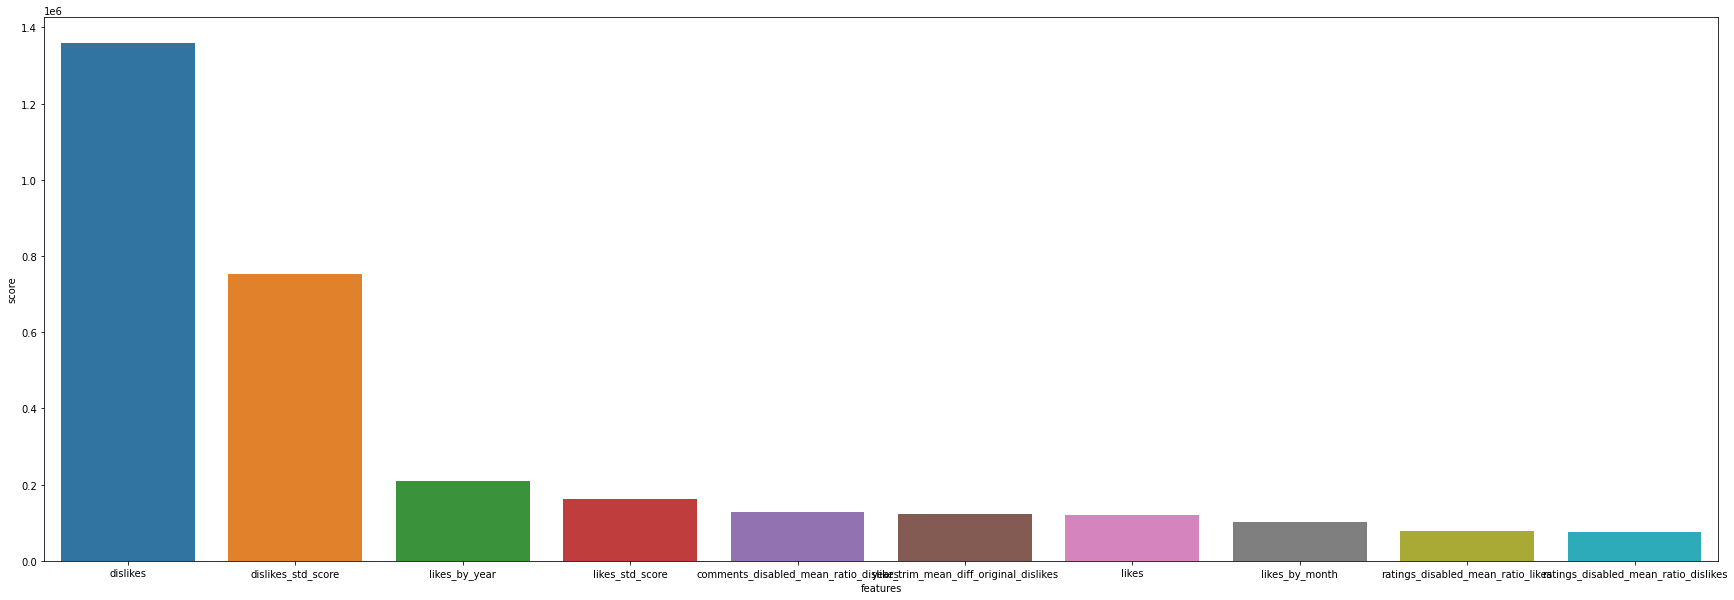

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
	
sns.barplot(x="features", y="score", data=fd)